# Initial study

This notebook identifies PPMI subjects to reproduce the following paper:


<div class="alert alert-block alert-success">
Shu, Zhen‐Yu, et al. <a href="https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.28522?casa_token=Ab53WvMlODcAAAAA%3AXcgDLmq8egqW7uwd2g3jY9jIljhLu3VhIbvMWgbcfoWOxjO_9H7Arf91t2FBZDZ8E94Je4Wmrn0ZmkeZ">Predicting the progression of Parkinson's disease using conventional MRI and machine learning: An application of radiomic biomarkers in whole‐brain white matter.</a> Magnetic Resonance in Medicine 85.3 (2021): 1611-1624.</div>

This study used the following population from PPMI:
<img src="./table.png"/>

Note: this notebook can be shared publicly. It is implemented to not leak any PPMI patient information or id.

# Data loading and preparation

## Metadata download

In [14]:
import os
import ppmi_downloader

data_dir = 'data'

# Download PPMI files
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
required_files = ['Age_at_visit.csv', 'Demographics.csv', 'Participant_Status.csv']
missing_files = [x for x in required_files if not os.path.exists(os.path.join(data_dir, x))]

if len(missing_files) > 0:
    ppmi = ppmi_downloader.PPMIDownloader()
    ppmi.download_metadata(missing_files, destination_dir=data_dir, headless=False, timeout=600)

## Hoehn & Yahr score

In [15]:
import pandas as pd
import numpy as np
import os

data_dir = 'data'

df_hy = pd.read_csv(os.path.join(data_dir, 'MDS_UPDRS_Part_III_clean_v0.1.csv'))

# Separate cohorts in OFF and ON medication groups
df_hy = df_hy[df_hy["PDSTATE"]=="OFF"]

# Drop useless columns
keep_cols = ['EVENT_ID', 'PATNO', 'NHY', 'PDSTATE', 'PDTRTMNT']
df_hy = df_hy.drop([x for x in df_hy.columns if x not in keep_cols], axis=1)

# Show H&Y stats
df_hy.groupby('PDSTATE').count()

C:\Users\MohanadArafe\AppData\Local\Temp\ipykernel_5608\296677578.py:7: DtypeWarning: Columns (10,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hy = pd.read_csv(os.path.join(data_dir, 'MDS_UPDRS_Part_III_clean_v0.1.csv'))


,PATNO,EVENT_ID,NHY,PDTRTMNT
PDSTATE,,,,
OFF,12601,12601,12594,12601


## Demographics

Needed for sex.

In [16]:
demo = pd.read_csv(os.path.join(data_dir, 'Demographics.csv'))

# Drop useless columns
keep = ['PATNO', 'SEX']
demo = demo.drop([x for x in demo.columns if x not in keep], axis=1)

#
demo['SEX'] = demo['SEX'].astype(int)

# Show sex stats (0: Female, 1: Male)
demo.groupby('SEX').count()

,PATNO
SEX,
0,976
1,1326


## Age at visit

<AxesSubplot:>

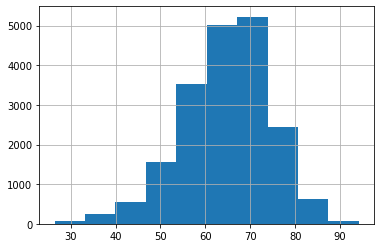

In [17]:
df_age = pd.read_csv(os.path.join(data_dir, 'Age_at_visit.csv'))

# Show histogram
df_age['AGE_AT_VISIT'].hist()

## MRI availability

In [18]:
# Read CSV
mri_df = pd.read_csv("./data/MRI_info_v0.1.csv")

# Keep rows with visits we need
# We need a 3-year gap between visits so the only possible pairs are the following ones:
visits = {'BL': 'V08', 
          'V04': 'V10',
          'V06': 'V12',
          'V08': 'V13',
          'V10': 'V14'}

mri_df.rename(columns={'Subject ID': 'PATNO', 'Visit code': 'EVENT_ID'}, inplace=True)
mri_df = mri_df[mri_df['EVENT_ID'].isin(visits)]
mri_df["PATNO"] = mri_df["PATNO"].astype(np.int64)
mri_df["Description"] = mri_df["Description"].astype(str)
mri_df.groupby('EVENT_ID').count()

,PATNO,Sex,Visit,Age,Description
EVENT_ID,,,,,
BL,1124,1124,1124,1124,1124
V04,270,270,270,270,270
V06,324,324,324,324,324
V08,2,2,2,2,2
V10,346,346,346,346,346


## Keep patients in PD group

In [19]:
# Read CSV | 1: PD, 2: Cohort
participant_df = pd.read_csv("./data/Participant_Status.csv")[["PATNO", "COHORT_DEFINITION"]]
participant_df = participant_df[participant_df["COHORT_DEFINITION"]=="Parkinson's Disease"]

participant_df.groupby('COHORT_DEFINITION').count()

,PATNO
COHORT_DEFINITION,
Parkinson's Disease,1137


## Merge H&Y, age and MRI information

In [55]:
keys = ['PATNO', 'EVENT_ID']

df_mri_age = df_age.merge(mri_df, how='right')
df_mri_age['AGE_AT_VISIT'].fillna(df_mri_age['Age'])
df_mri_age = df_mri_age.merge(participant_df, on="PATNO")

df = df_hy.merge(df_mri_age, how='inner')
df.groupby('NHY').count()

,PATNO,EVENT_ID,PDSTATE,PDTRTMNT,AGE_AT_VISIT,Sex,Visit,Age,Description,COHORT_DEFINITION
NHY,,,,,,,,,,
1,235,235,235,235,235,235,235,235,235,235
2,588,588,588,588,588,588,588,588,588,588
3,36,36,36,36,36,36,36,36,36,36
4,6,6,6,6,6,6,6,6,6,6
UR,1,1,1,1,1,1,1,1,1,1


## Format data by visit pairs

In [56]:
def next_visit(x):
    return visits[x]

In [57]:
visits_df = df

# Set id of second visit in pair
visits_df['next_visit'] = visits_df['EVENT_ID'].apply(next_visit)

# Retrieve H&Y score of next visit
visits_df = visits_df.merge(df_hy, how='left', left_on=['PATNO', 'next_visit'], right_on=['PATNO', 'EVENT_ID'])

# Add patient sex to visit pairs
visits_df = visits_df.merge(demo, on=['PATNO'])

# Define visit as stable if NHY (first visit)
visits_df['stable'] = (visits_df['NHY_x'] == visits_df['NHY_y'])

In [58]:
visits_df.groupby(['stable', 'NHY_x'], dropna=False).count()

PATNO  EVENT_ID_x  PDSTATE_x  PDTRTMNT_x  AGE_AT_VISIT  Sex  \
stable NHY_x                                                                
False  1        200         200        200         200           200  200   
       2        346         346        346         346           346  346   
       3         35          35         35          35            35   35   
       4          6           6          6           6             6    6   
       UR         1           1          1           1             1    1   
       NaN        1           1          1           1             1    1   
True   1         35          35         35          35            35   35   
       2        242         242        242         242           242  242   
       3          1           1          1           1             1    1   

              Visit  Age  Description  COHORT_DEFINITION  next_visit  \
stable NHY_x                                                           
False  1        200  200          200                200         200   
       2        346  346          346                346         346   
       3         35   35           35                 35          35   
       4          6    6            6                  6           6   
       UR         1    1            1                  1           1   
       NaN        1    1            1                  1           1   
True   1         35   35           35                 35          35   
       2        242  242          242                242         242   
       3          1    1            1                  1           1   

              EVENT_ID_y  PDSTATE_y  NHY_y  PDTRTMNT_y  SEX  
stable NHY_x                                                 
False  1             102        102    102         102  200  
       2              48         48     48          48  346  
       3               7          7      7           7   35  
       4               2          2      2           2    6  
       UR              0          0      0           0    1  
       NaN             0          0      0           0    1  
True   1              35         35     35          35   35  
       2             242        242    242         242  242  
       3               1          1      1           1    1

In [62]:
visits_df[visits_df["PATNO"]==3268]

,PATNO,EVENT_ID_x,PDSTATE_x,NHY_x,PDTRTMNT_x,AGE_AT_VISIT,Sex,Visit,Age,Description,COHORT_DEFINITION,next_visit,EVENT_ID_y,PDSTATE_y,NHY_y,PDTRTMNT_y,SEX,stable
164,3268,BL,OFF,2,0.0,61.5,M,Baseline,61.5,SAG FSPGR 3D,Parkinson's Disease,V08,NaN,NaN,NaN,NaN,1,False


### Drop defective MRI scans

In [26]:
visits_df = visits_df.drop(visits_df[visits_df["PATNO"]==3268].index)
visits_df = visits_df.drop(visits_df[(visits_df["PATNO"]==3328) & (visits_df["EVENT_ID_x"]=="BL")].index)
visits_df = visits_df.drop(visits_df[visits_df["PATNO"]==3275].index)
visits_df = visits_df.drop(visits_df[(visits_df["PATNO"]==3802) & (visits_df["EVENT_ID_x"]=="BL")].index)

# Matching

We implemented a nearest-neighbor matching loop based on the Euclidean distance. We will match stable and progressive groups for age and sex for each H&Y value.

## Normalization

We need to normalize age or else it will dominate sex in the Euclidean distance.

In [27]:
df = visits_df
to_normalize = ['AGE_AT_VISIT'] 
for var in to_normalize:
    df[f'{var}_norm'] = (df[var] - df[var].mean())/df[var].std()
df.describe()

,PATNO,PDTRTMNT_x,AGE_AT_VISIT,Age,PDTRTMNT_y,SEX,AGE_AT_VISIT_norm
count,863.000000,863.000000,863.000000,863.00000,436.000000,863.000000,8.630000e+02
mean,20634.640788,0.453071,63.247972,63.25898,0.935780,0.652375,-3.622698e-16
std,31346.357130,0.498081,9.510701,9.51196,0.245426,0.476492,1.000000e+00
min,3001.000000,0.000000,33.700000,33.70000,0.000000,0.000000,-3.106813e+00
25%,3352.000000,0.000000,56.400000,56.45000,1.000000,0.000000,-7.200281e-01
50%,3800.000000,0.000000,64.400000,64.40000,1.000000,1.000000,1.211296e-01
75%,40692.000000,1.000000,70.500000,70.50000,1.000000,1.000000,7.625125e-01
max,142957.000000,1.000000,86.300000,86.30000,1.000000,1.000000,2.423799e+00


## Matching loop

Nearest neighbor matching loop applied for each H&Y value to extract stable and progressive populations with matched sex and age.

In [28]:
def nn(x, df, matched_vars):
    '''
    Find index of nearest neighbor of x in df
    '''
    
    # Select only the subjects with the same H&Y score
    df_hy_match = df[df['NHY_x'] == x['NHY_x'].values[0]]
 
    # Compute squared distance between x and all elements in df, using normalized variables
    df_hy_match['dist'] = sum((df_hy_match[f'{var}']-x[f'{var}'].values[0])**2 for var in matched_vars)
    
    # Return the element in df with the smallest distance
    df_hy_match.sort_values('dist', inplace=True)
    return df_hy_match.head(1)  ## there's probably a better way to do it but it should work

def match(n, group1_df, group2_df, matched_vars):
    '''
    Randomly pick n elements in group1_df, then find n matching elements in group2_df.
    Ensure that each group only contains 1 or less element from each patient and that 
    no patient has elements in both groups.
    '''
    
    from numpy.random import choice, seed

    # Select n random patients in group1
    group1_patnos = sorted(pd.unique(group1_df['PATNO']))
    seed(0)  # change this to bootstrap population
    group1_patnos_sample = choice(group1_patnos, n, replace=False)
    
    # Remove the selected patients from group2
    for p in group1_patnos_sample:
        group2_df = group2_df[group2_df['PATNO']!=p]
    
    group1_matched = pd.DataFrame(columns=group1_df.columns)
    group2_matched = pd.DataFrame(columns=group1_df.columns)

    for p in group1_patnos_sample:  # for each patient in sampled list
        # Pick a random element from this patient in group1
        s = group1_df[group1_df['PATNO'] == p].sample(1)
        # Find the best match in group2
        t = nn(s, group2_df, matched_vars)
        # Add s and t to matched groups
        group1_matched = group1_matched.append(s)
        group2_matched = group2_matched.append(t)
        # Remove t's patient from group 2 so that it doesn't get selected again
        group2_df = group2_df[group2_df['PATNO']!=t['PATNO'].values[0]]
    
    return group1_matched, group2_matched

matched_vars = ['AGE_AT_VISIT_norm', 'SEX']

        
# # Apply matching to get 47 patients with H&Y=1
stable1, progr1 = match(29,
                        df[(df['stable'] == True) & (df['NHY_x'] == "1")],
                        df[(df['stable'] == False) & (df['NHY_x'] == "1")],
                        matched_vars)
patids = pd.unique(pd.concat([stable1, progr1], axis=0)["PATNO"])
df_filtered = df[~df['PATNO'].isin(patids)]

# # Apply matching to get 25 patients with H&Y=2
stable2, progr2 = match(43,
                        df_filtered[(df_filtered['stable'] == True) & (df_filtered['NHY_x'] == "2")],
                        df_filtered[(df_filtered['stable'] == False) & (df_filtered['NHY_x'] == "2")],
                        matched_vars)


C:\Users\MohanadArafe\AppData\Local\Temp\ipykernel_5608\149931291.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group1_matched = group1_matched.append(s)
C:\Users\MohanadArafe\AppData\Local\Temp\ipykernel_5608\149931291.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group2_matched = group2_matched.append(t)
C:\Users\MohanadArafe\AppData\Local\Temp\ipykernel_5608\149931291.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group1_matched = group1_matched.append(s)
C:\Users\MohanadArafe\AppData\Local\Temp\ipykernel_5608\149931291.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group2_matched = group2_matched.append(t)


C:\Users\MohanadArafe\AppData\Local\Temp\ipykernel_5608\149931291.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group2_matched = group2_matched.append(t)
C:\Users\MohanadArafe\AppData\Local\Temp\ipykernel_5608\149931291.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group1_matched = group1_matched.append(s)
C:\Users\MohanadArafe\AppData\Local\Temp\ipykernel_5608\149931291.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group2_matched = group2_matched.append(t)
C:\Users\MohanadArafe\AppData\Local\Temp\ipykernel_5608\149931291.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group1_matched = group1_matched.append(s)


C:\Users\MohanadArafe\AppData\Local\Temp\ipykernel_5608\149931291.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group1_matched = group1_matched.append(s)
C:\Users\MohanadArafe\AppData\Local\Temp\ipykernel_5608\149931291.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group2_matched = group2_matched.append(t)
C:\Users\MohanadArafe\AppData\Local\Temp\ipykernel_5608\149931291.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group1_matched = group1_matched.append(s)
C:\Users\MohanadArafe\AppData\Local\Temp\ipykernel_5608\149931291.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group2_matched = group2_matched.append(t)


C:\Users\MohanadArafe\AppData\Local\Temp\ipykernel_5608\149931291.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group1_matched = group1_matched.append(s)
C:\Users\MohanadArafe\AppData\Local\Temp\ipykernel_5608\149931291.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group2_matched = group2_matched.append(t)
C:\Users\MohanadArafe\AppData\Local\Temp\ipykernel_5608\149931291.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group1_matched = group1_matched.append(s)
C:\Users\MohanadArafe\AppData\Local\Temp\ipykernel_5608\149931291.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group2_matched = group2_matched.append(t)


In [29]:
stable = stable1.append(stable2)
progr = progr1.append(progr2)

C:\Users\MohanadArafe\AppData\Local\Temp\ipykernel_5608\2664523030.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stable = stable1.append(stable2)
C:\Users\MohanadArafe\AppData\Local\Temp\ipykernel_5608\2664523030.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  progr = progr1.append(progr2)


## Sanity checks

In [30]:
for (a, b) in [(stable1, progr1), (stable2, progr2)]:
    # Both groups have equal size
    assert(len(a) == len(b))
    # No patient is present more than once in each group
    for x in [a, b]:
        patnos_x = pd.unique(x['PATNO'])
        assert(len(patnos_x)==len(x)), x
    # Patients in a aren't in b
    patnos_a = pd.unique(a['PATNO'])
    patnos_b = pd.unique(b['PATNO'])
    for p in patnos_a:
        assert(p not in patnos_b), f'PATNO {p} appears in a and b'
        
# Patients in each cohort do not replicate
assert len(set(pd.unique(progr["PATNO"])) & (set(pd.unique(stable["PATNO"]))))==0, "Patients occur in both groups"

print('All good!')

All good!


## Cohort summary

In [31]:
import os
print(f"\t\t\t\t\t| Stable set (n={len(stable)})\t| Progression set (n={len(progr)})" + os.linesep +
       f"Age (years) \t\t\t\t| {round(stable['AGE_AT_VISIT'].mean(),2)} \t\t| {round(progr['AGE_AT_VISIT'].mean(),2)}" + os.linesep + 
       f"Gender [male (n)] \t\t\t| {len(stable[stable['SEX']==1])} \t\t\t| {len(progr[progr['SEX']==1])}" + os.linesep +
       f"Hoehn & Yahr (n) \t Stage 1 \t| {len(stable[stable['NHY_x']=='1'])} \t\t\t| {len(progr[progr['NHY_x']=='1'])}" + os.linesep +
       f"\t\t\t Stage 2 \t| {len(stable[stable['NHY_x']=='2'])} \t\t\t| {len(progr[progr['NHY_x']=='2'])}" + os.linesep +
       f"\t\t\t Stage 3 \t| {len(stable[stable['NHY_x']=='3'])} \t\t\t| {len(progr[progr['NHY_x']=='3'])}"

)

					| Stable set (n=72)	| Progression set (n=72)
Age (years) 				| 61.32 		| 61.25
Gender [male (n)] 			| 45 			| 45
Hoehn & Yahr (n) 	 Stage 1 	| 29 			| 29
			 Stage 2 	| 43 			| 43
			 Stage 3 	| 0 			| 0


<AxesSubplot:>

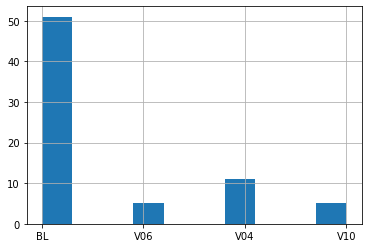

In [32]:
stable['EVENT_ID_x'].hist()

<AxesSubplot:>

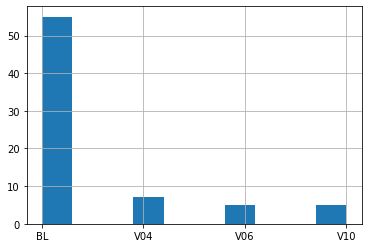

In [33]:
progr['EVENT_ID_x'].hist()

### Patients breakdown

In [34]:
for visit in stable["EVENT_ID_x"].unique():
    print(f"FOR VISIT: {visit} - {len(stable[stable['EVENT_ID_x'] == visit]['PATNO'].values)} patients")
    print(','.join(map(str, stable[stable["EVENT_ID_x"] == visit]["PATNO"].values)))

FOR VISIT: BL - 51 patients
3173,3832,3960,3430,3421,4096,51440,4117,3431,3838,3130,3420,52530,3322,3824,3419,3327,3961,3061,3661,3429,4076,3116,3089,3436,3088,4102,41829,41420,3653,3018,4101,4098,55875,3285,40585,3577,4126,3254,3564,3575,3433,3528,3028,4077,3068,40714,3501,4108,40744,3504
FOR VISIT: V06 - 5 patients
3308,40366,41664,3124,3586
FOR VISIT: V04 - 11 patients
3328,3808,3815,3307,3819,3175,3834,3166,3585,3181,4019
FOR VISIT: V10 - 5 patients
3822,3325,4029,3127,3826


In [35]:
for visit in progr["EVENT_ID_x"].unique():
    print(f"FOR VISIT: {visit} - {len(progr[progr['EVENT_ID_x'] == visit]['PATNO'].values)} patients")
    print(','.join(map(str, progr[progr["EVENT_ID_x"] == visit]["PATNO"].values)) )

FOR VISIT: BL - 55 patients
4054,3111,3024,3272,3108,4055,3167,3123,3664,75505,3825,3269,137426,3634,3174,115448,124793,3309,3593,3829,3185,3869,3184,4051,102003,3630,3407,101295,71935,3387,4035,140041,102479,3609,4078,3530,3762,4070,3012,3633,3764,3014,4136,3020,121619,3080,3179,120544,41749,3383,3314,3010,3007,3251,3366
FOR VISIT: V04 - 7 patients
3752,4082,3375,3360,3352,4034,4030
FOR VISIT: V06 - 5 patients
4081,40534,3558,3557,52678
FOR VISIT: V10 - 5 patients
56744,53339,51632,40735,41438


In [36]:
stable["PATNO"].values

array([3173, 3832, 3960, 3430, 3421, 4096, 51440, 4117, 3308, 3431, 3328,
       3808, 3838, 3815, 3130, 3420, 52530, 3322, 3307, 3819, 3824, 3419,
       3327, 3961, 3175, 3061, 3834, 3661, 3429, 4076, 40366, 3116, 3822,
       3089, 3436, 3166, 3088, 3585, 4102, 41829, 41420, 3325, 3653, 3018,
       4101, 4098, 3181, 55875, 3285, 4029, 40585, 3577, 3127, 4126,
       41664, 3124, 4019, 3826, 3254, 3564, 3586, 3575, 3433, 3528, 3028,
       4077, 3068, 40714, 3501, 4108, 40744, 3504], dtype=object)

In [37]:
progr["PATNO"].values

array([4054, 3111, 3024, 3752, 3272, 3108, 4055, 3167, 3123, 3664, 75505,
       3825, 3269, 137426, 3634, 3174, 115448, 124793, 4082, 3309, 3593,
       3829, 3185, 3869, 3184, 4051, 102003, 3630, 3407, 4081, 101295,
       71935, 56744, 3387, 3375, 4035, 140041, 102479, 3609, 4078, 3530,
       3762, 4070, 53339, 51632, 3012, 3633, 40735, 3360, 3352, 3764,
       3014, 41438, 4136, 3020, 121619, 4034, 3080, 3179, 40534, 3558,
       3557, 120544, 41749, 4030, 3383, 52678, 3314, 3010, 3007, 3251,
       3366], dtype=object)

In [51]:
len(set(np.concatenate((progr["PATNO"].values, stable["PATNO"].values))).intersection(set(pd.read_csv("../data/volume-data/freeSurferVolumes.csv")["subjectId"])))

144

visits = {'BL': 'V08', 
          'V04': 'Month 12',
          'V06': 'Month 24',
          'V08': 'Month 36',
          'V10': 'Month 48'}